In [1]:
import numpy as np
import scipy.io.wavfile as wav
from scipy import signal
from scipy.signal import butter, lfilter, zpk2tf
from matplotlib import pyplot as plt
from IPython.display import Audio
import functools
import copy
import time as t

In [2]:
Fs, data = wav.read('../audio/xkrato61.wav')

In [3]:
sample_rate = Fs
length_in_samples = np.size(data)
length_in_s = length_in_samples/Fs

print(f"Sample rate: {sample_rate} Hz")
print(f"Length: {length_in_s} s")
print(f"Length: {length_in_samples} samples")
print(f"Maximum in samples: {np.amax(data)}")
print(f"Minimum in samples: {np.amin(data)}")

Sample rate: 16000 Hz
Length: 2.9248125 s
Length: 46797 samples
Maximum in samples: 3427
Minimum in samples: -2953


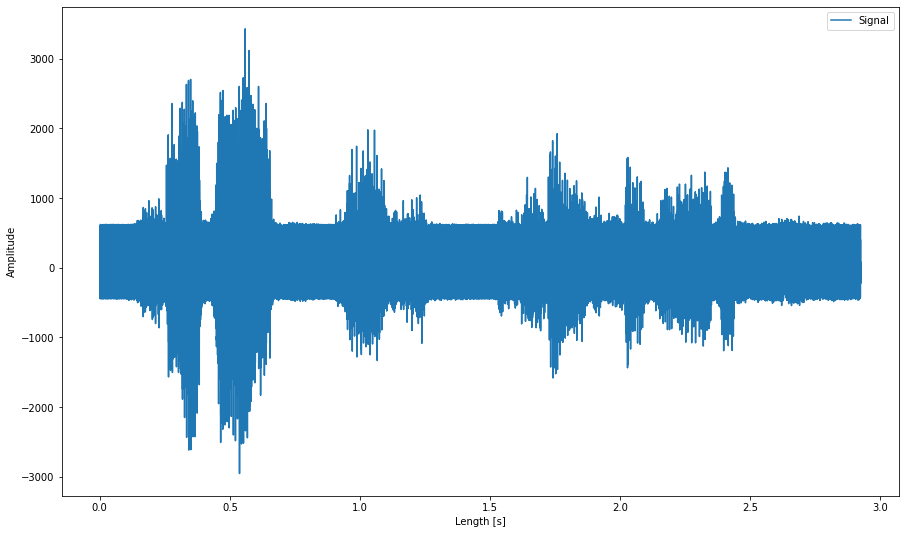

In [4]:
Time = np.linspace(0, np.size(data)/Fs, num=np.size(data))
plt.figure(figsize=(15, 9))
plt.plot(Time, data, label='Signal')
plt.ylabel('Amplitude')
plt.xlabel('Length [s]')
plt.legend()
plt.show()

In [5]:
# normalizing while keeping the original signal data
normalized_data = copy.deepcopy(data)
# DC offset removal
normalized_data = normalized_data - np.mean(normalized_data)
normalized_data = normalized_data / np.abs(normalized_data).max()

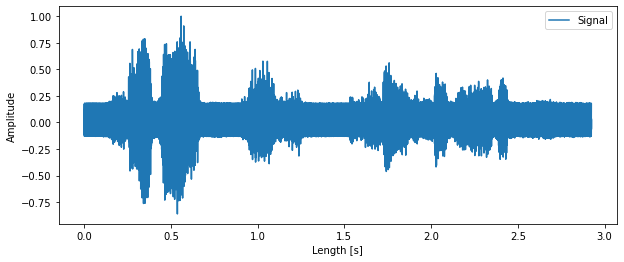

In [6]:
# Graph of normalized data, shape should be same, max amplitude is 1
Time = np.linspace(0, np.size(data)/Fs, num=np.size(data))
plt.figure(figsize=(10, 4))
plt.plot(Time, normalized_data, label='Signal')
plt.ylabel('Amplitude')
plt.xlabel('Length [s]')
plt.legend()
plt.show()

In [7]:
# -1 to discard the last two uncomplete frames, it is not -2 because the list numbering starts from zero
number_of_frames = np.size(data)//512 - 1

In [8]:
# defining matrix of 1024 rows and number_of_frames cols 
matrix = np.zeros((1024, number_of_frames))

In [9]:
# saving frames as columns of matrix
for i in range(0, number_of_frames):
    matrix[:, [i]] = data[i*512: i*512 + 1024].reshape((1024, 1))

In [10]:
# defining horizontal axis
Time = np.linspace(0, 1024/Fs, num=1024)
'''
# plotting each frame to choose the best (periodic voiced) one
for i in range(number_of_frames):
    plt.figure(figsize=(10, 4))
    plt.title(f"Frame number: {i}")
    plt.plot(Time, matrix[:, [i]])
    plt.ylabel('Amplitude')
    plt.xlabel('Seconds [s]')
    plt.show()
'''
# after thorough consideration, I decided to choose frame no. 17 (18th from the beggining)
frame_number = 17
frame = matrix[:, [frame_number]]

In [11]:
# audio of chosen frame confirms it is voiced
Audio(data=frame.flatten(), rate=Fs)

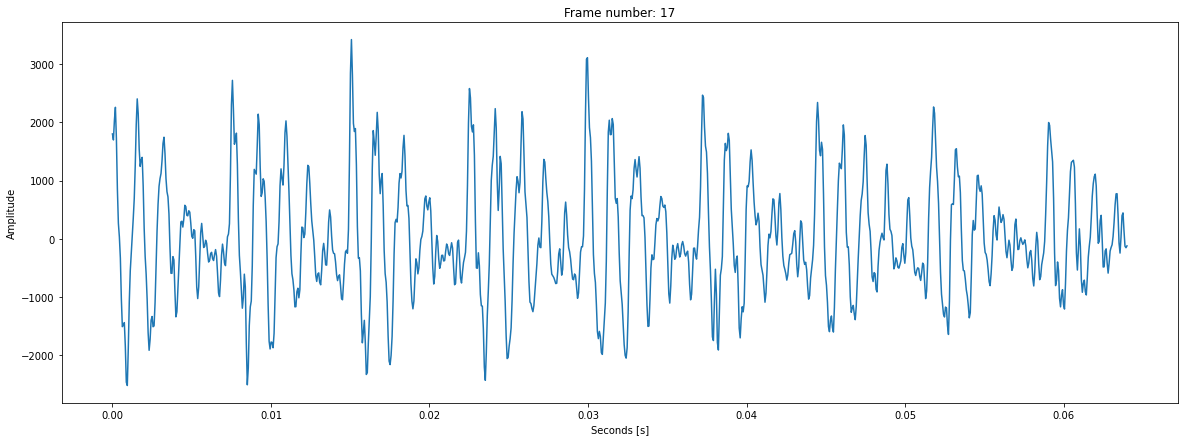

In [12]:
plt.figure(figsize=(20, 7))
plt.title(f"Frame number: {17}")
plt.plot(Time, frame)
plt.ylabel('Amplitude')
plt.xlabel('Seconds [s]')
plt.show()

In [13]:
def timeit(f):
    def timed(*args, **kw):
        ts = t.time()
        f(*args, **kw)
        te = t.time()
        print (f"{f.__name__} took: {te-ts} sec")
    return timed

In [14]:
# DFT with my slow DFT implementation

# list for saving N frequency values
X_slow = []
N = 1024
x_values = np.arange(0, N, 1)

@timeit
def my_slow_dft(array):
    global X_slow
    for k in range(0, N):
        X_slow.append(0+0j)
        for n in range(0, N):
            X_slow[k] += array[n][0] * np.exp(-1j*2*np.pi*k*n/N)
my_slow_dft(frame)

my_slow_dft took: 1.8409678936004639 sec


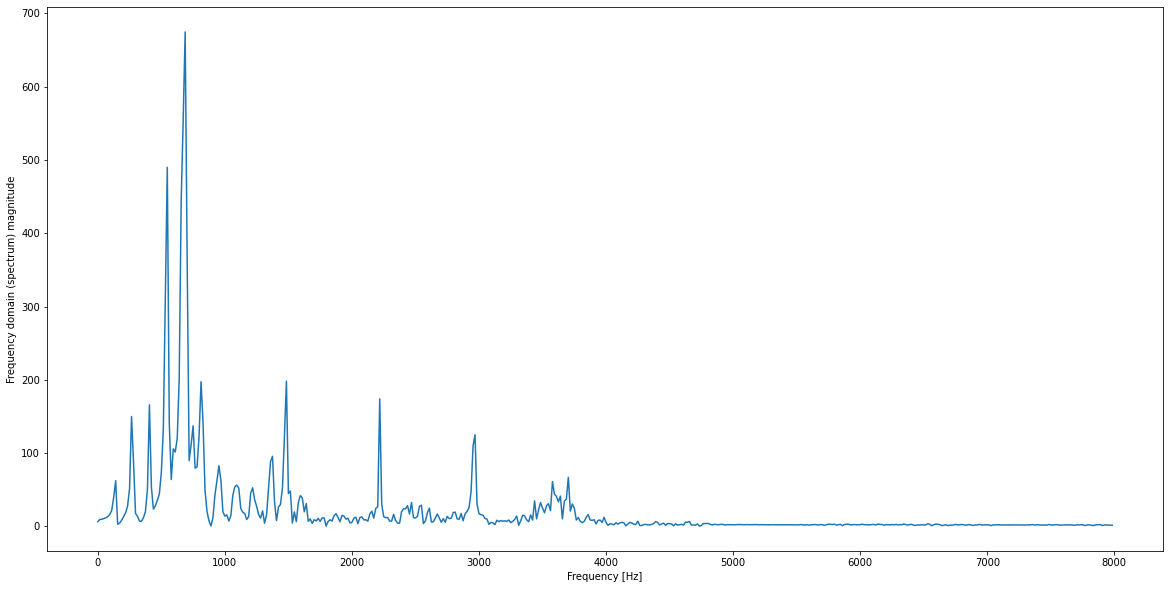

In [15]:
# Plot in frequency domain

# calculating all powers
powers_all_slow = np.abs(np.divide(X_slow, N/2))
# Selecting frequency values 0...N/2
powers_slow = powers_all_slow[0:int(N/2)]

# Adjusting to time domain
frequencies_slow = np.divide(np.multiply(Fs, np.arange(0, N/2)), N)

plt.figure(figsize=(20, 10))
plt.ylabel('Frequency domain (spectrum) magnitude')
plt.xlabel('Frequency [Hz]')
plt.plot(frequencies_slow, powers_slow)
plt.show()

In [16]:
@timeit
def fast_fft(frame):
    global X_fast
    X_fast = np.fft.fft(frame.flatten())

fast_fft(frame)

fast_fft took: 0.0001499652862548828 sec


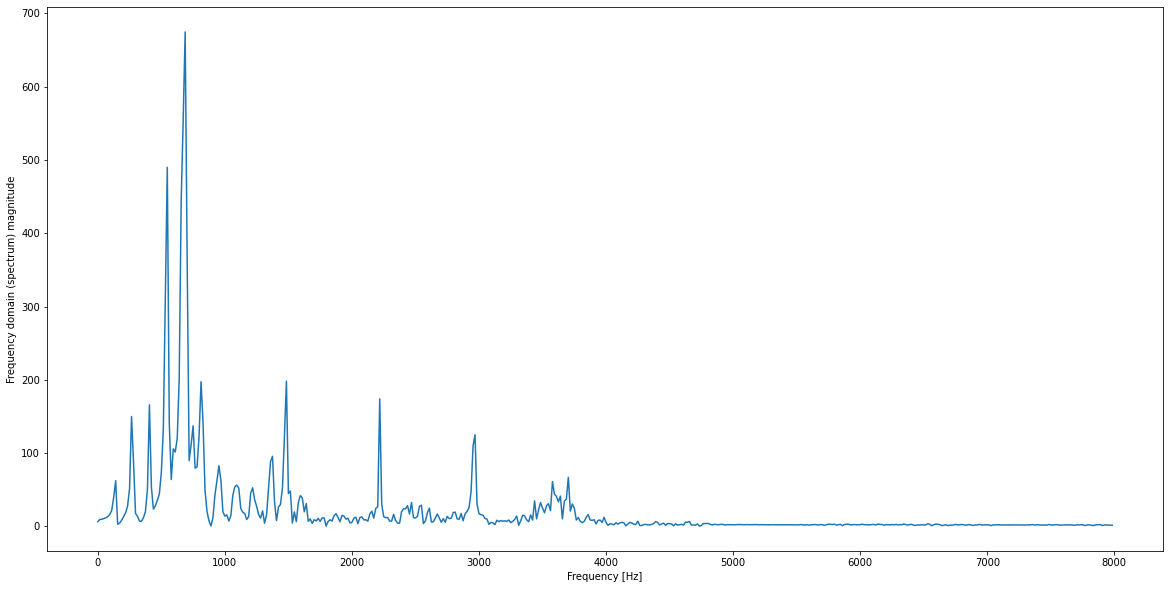

In [17]:
frequencies_fast = np.fft.fftfreq(np.size(frame), d=1/Fs)[0:int(N/2)]
# Plot in frequency domain

# calculating all powers
powers_all_fast = np.abs(np.divide(X_fast, N/2))
# Selecting frequency values 0...N/2
powers_fast = powers_all_fast[0:int(N/2)]

#X_fast_list = X_fast.tolist()

plt.figure(figsize=(20, 10))
plt.ylabel('Frequency domain (spectrum) magnitude')
plt.xlabel('Frequency [Hz]')
plt.plot(frequencies_fast, powers_fast)
plt.show()

In [18]:
# Correlation between DFT implemented by myself and its optimized version from numpy library
print(f"Correlation between two implementations: {np.allclose(X_slow, X_fast, rtol=1e-10) }")

# However the difference in execution time is roughly 3.25s

Correlation between two implementations: True


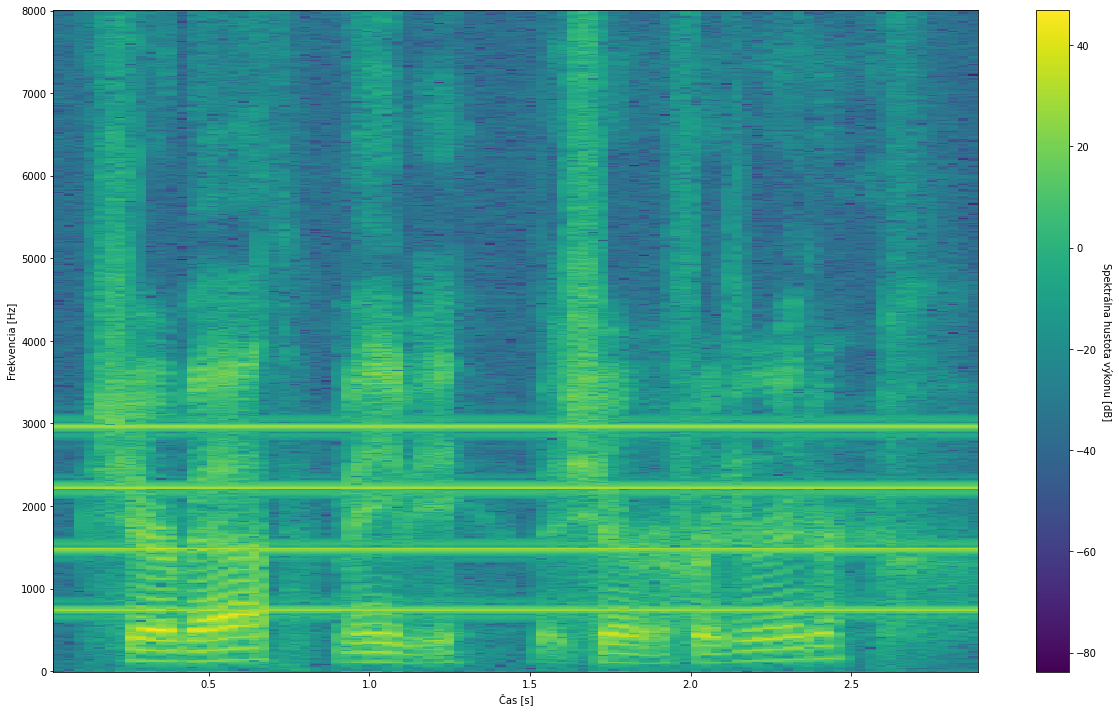

In [19]:
f, t, sgr = signal.spectrogram(data, Fs, nperseg=1024, noverlap=512)
# prevod na PSD
sgr_log = 10 * np.log10(sgr+1e-20) 

plt.figure(figsize=(17, 10))
plt.pcolormesh(t,f,sgr_log, shading='auto')
plt.gca().set_xlabel('Čas [s]')
plt.gca().set_ylabel('Frekvencia [Hz]')
cbar = plt.colorbar()
cbar.set_label('Spektrálna hustota výkonu [dB]', rotation=270, labelpad=15)
plt.tight_layout()

# Resulting frequencies are harmonically related and the base frequency is approx. 740Hz
base_freq = 740

In [20]:
t = np.arange(np.size(data))

# setting amplitude for better visual result
cos1 = 0.5*np.cos(2*(np.pi/Fs)*1*base_freq*t)
cos2 = 0.5*np.cos(2*(np.pi/Fs)*2*base_freq*t)
cos3 = 0.5*np.cos(2*(np.pi/Fs)*3*base_freq*t)
cos4 = 0.5*np.cos(2*(np.pi/Fs)*4*base_freq*t)

cos = cos1 + cos2 + cos3 + cos4

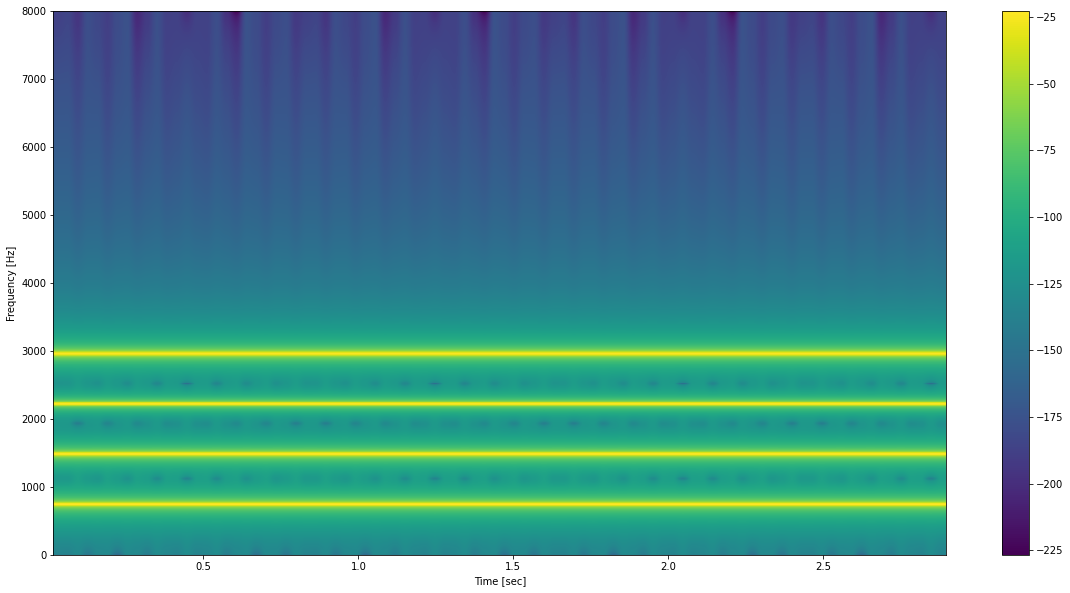

In [21]:
plt.figure(figsize=(20, 10))
plt.specgram(cos, Fs=Fs, NFFT=1024, noverlap=512, mode='psd', scale='dB')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.show()

In [22]:
# Noise audio export
wav.write('../audio/4cos.wav', Fs, cos)

In [23]:
frame_size = 1024
shift = 512

frames = np.array([data[i*shift:i*shift + frame_size] for i in range(len(data) //shift - frame_size//shift + 1)])
filtered_X = np.array([np.abs(np.fft.fft(x)) for x in frames])

a_coeffs = []
a_coeffs_grouped = []
b_coeffs = []
b_coeffs_grouped = []

# source: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
def butter_bandstop(cut_freq, fs, order=5):
    #global a_coeffs, b_coeffs
    nyq = 0.5 * fs
    # division by nyquist frequency
    low_pass = (cut_freq - 50) / nyq
    high_pass = (cut_freq + 50) / nyq
    low_stop = (cut_freq - 15) / nyq
    high_stop = (cut_freq + 15) / nyq
    # computing order N and 
    N, Wn = signal.buttord([low_pass, high_pass], [low_stop, high_stop], 3, 30)
    b, a  = butter(N, Wn, btype='bandstop', output='ba')
    # appending to unique coefficients lists
    a_coeffs_grouped.append(a)
    b_coeffs_grouped.append(b)
    [a_coeffs.append(x) for x in a if x not in a_coeffs]
    [b_coeffs.append(x) for x in b if x not in b_coeffs]
    
    return b, a

def butter_bandstop_filter(data, cut_freq, fs, order=5):
    b, a = butter_bandstop(cut_freq, fs, order=order)
    y = lfilter(b, a, data)
    return y

filter_width = 15 # 1/2 filter width

spectras = []
frame = filtered_X[frame_number]
spectras.append(frame)

xfilts = []
xfilts.append(data)
x_filt = copy.deepcopy(data)

# [1 2 3 4] for multiplying base frequency
for i in range(1, 5):
    # returns filtered data
    x_filt = butter_bandstop_filter(x_filt, i*base_freq, Fs)
    
    xfilts.append(x_filt)
    frame = np.abs(np.fft.fft(x_filt[frame_number*shift:frame_number*shift + frame_size], n=1024))
    spectras.append(frame)

np.set_printoptions(precision=2)
print("Koeficienty a: ", end='')
print(np.array(a_coeffs))
print("")
print("Koeficienty b: ", end='')
print(np.array(b_coeffs))

Koeficienty a: [  1.    -5.68  13.66 -17.84  13.32  -5.39   0.93  -4.95  11.09 -14.14
  10.81  -4.7    0.93  -3.81   7.76  -9.47   7.56  -3.62   0.93  -2.35
   4.77  -5.06   4.64  -2.23   0.92]

Koeficienty b: [  0.96  -5.53  13.49 -17.84  13.49  -5.53   0.96   0.96  -4.82  10.95
 -14.14  10.95  -4.82   0.96   0.96  -3.71   7.66  -9.48  -3.71   0.96
   0.96  -2.29   4.71  -5.07   4.71  -2.29]


In [24]:
'''
# zobrazenie spektier signalu po odstraneni rusivych frekvencii
f, ax = plt.subplots(len(spectras), figsize=(15, len(spectras)*5))
for s in range(len(spectras)):
    ax[s].set_title(f'Spektrum signalu po odstraneni {s} nasobku {base_freq} Hz')
    ax[s].plot((np.arange(frame_size)/frame_size * Fs)[:frame_size//2], spectras[s].T[:len(spectras[s])//2])
plt.tight_layout()
'''

"\n# zobrazenie spektier signalu po odstraneni rusivych frekvencii\nf, ax = plt.subplots(len(spectras), figsize=(15, len(spectras)*5))\nfor s in range(len(spectras)):\n    ax[s].set_title(f'Spektrum signalu po odstraneni {s} nasobku {base_freq} Hz')\n    ax[s].plot((np.arange(frame_size)/frame_size * Fs)[:frame_size//2], spectras[s].T[:len(spectras[s])//2])\nplt.tight_layout()\n"

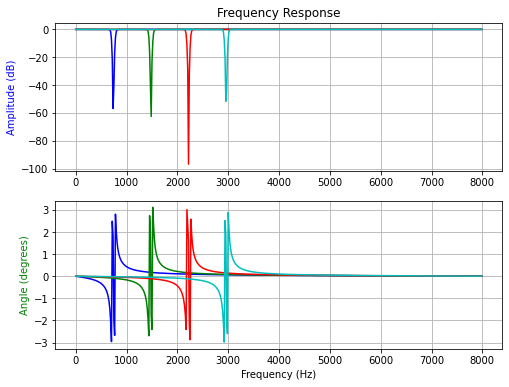

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
colors = ['b', 'g', 'r', 'c']
for i in range(1, 5):
    w, h = signal.freqz(*butter_bandstop(i*base_freq, Fs))
    ax[0].plot(w/np.pi*Fs/2, 20 * np.log10(abs(h)), colors[i-1])
    ax[1].plot(w/np.pi*Fs/2, np.angle(h), colors[i-1])
ax[0].set_title("Frequency Response")
ax[0].set_ylabel("Amplitude (dB)", color='blue')
ax[0].grid()
ax[1].set_ylabel("Angle (degrees)", color='green')
ax[1].set_xlabel("Frequency (Hz)")

ax[1].grid()
plt.show()


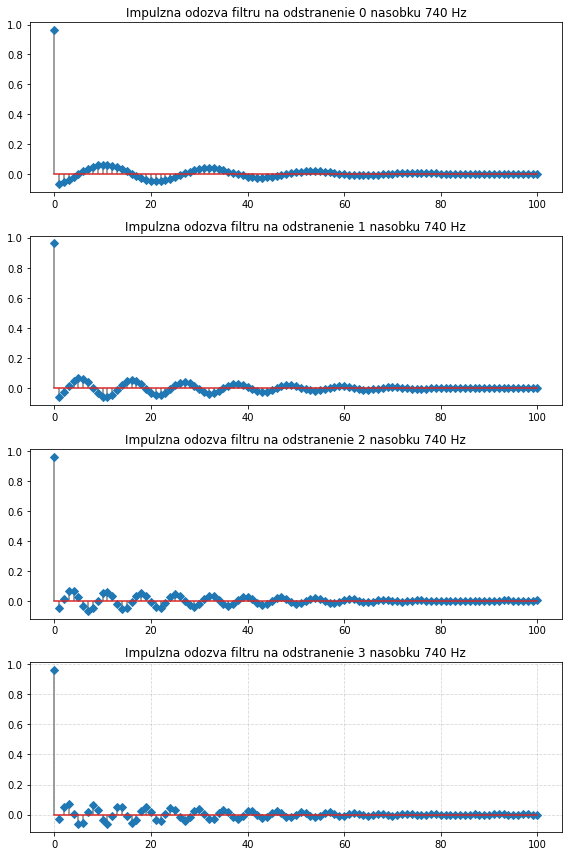

In [26]:
# array filled with zeros
N_imp = 101
imp = [1, *np.zeros(N_imp-1)]
fig, ax = plt.subplots(4, 1, figsize=(8, 12))

for i in range(4):
    h = lfilter(b_coeffs_grouped[i], a_coeffs_grouped[i], imp)
    ax[i].set_title(f'Impulzna odozva filtru na odstranenie {i} nasobku {base_freq} Hz')
    ax[i].stem(np.arange(N_imp), h, use_line_collection=True, linefmt='grey', markerfmt='D')
    
plt.tight_layout()
plt.grid(alpha=0.5, linestyle='--')

In [27]:
poles = []
zeros = []
for b_coef in b_coeffs_grouped:
    zeros.append(np.roots(b_coef))
for a_coef in a_coeffs_grouped:
    poles.append(np.roots(a_coef))

print("Poly:")
print(poles)
print()
print("Nuly:")
print(zeros)

Poly:
[array([0.94+0.3j , 0.94-0.3j , 0.95+0.27j, 0.95-0.27j, 0.94+0.28j,
       0.94-0.28j]), array([0.82+0.56j, 0.82-0.56j, 0.84+0.53j, 0.84-0.53j, 0.82+0.54j,
       0.82-0.54j]), array([0.62+0.77j, 0.62-0.77j, 0.65+0.75j, 0.65-0.75j, 0.63+0.75j,
       0.63-0.75j]), array([0.38+0.92j, 0.38-0.92j, 0.41+0.9j , 0.41-0.9j , 0.39+0.9j ,
       0.39-0.9j ]), array([0.94+0.3j , 0.94-0.3j , 0.95+0.27j, 0.95-0.27j, 0.94+0.28j,
       0.94-0.28j]), array([0.82+0.56j, 0.82-0.56j, 0.84+0.53j, 0.84-0.53j, 0.82+0.54j,
       0.82-0.54j]), array([0.62+0.77j, 0.62-0.77j, 0.65+0.75j, 0.65-0.75j, 0.63+0.75j,
       0.63-0.75j]), array([0.38+0.92j, 0.38-0.92j, 0.41+0.9j , 0.41-0.9j , 0.39+0.9j ,
       0.39-0.9j ])]

Nuly:
[array([0.96+0.29j, 0.96-0.29j, 0.96+0.29j, 0.96-0.29j, 0.96+0.29j,
       0.96-0.29j]), array([0.84+0.55j, 0.84-0.55j, 0.84+0.55j, 0.84-0.55j, 0.84+0.55j,
       0.84-0.55j]), array([0.64+0.77j, 0.64-0.77j, 0.64+0.77j, 0.64-0.77j, 0.64+0.77j,
       0.64-0.77j]), array([0.4+0.92j,

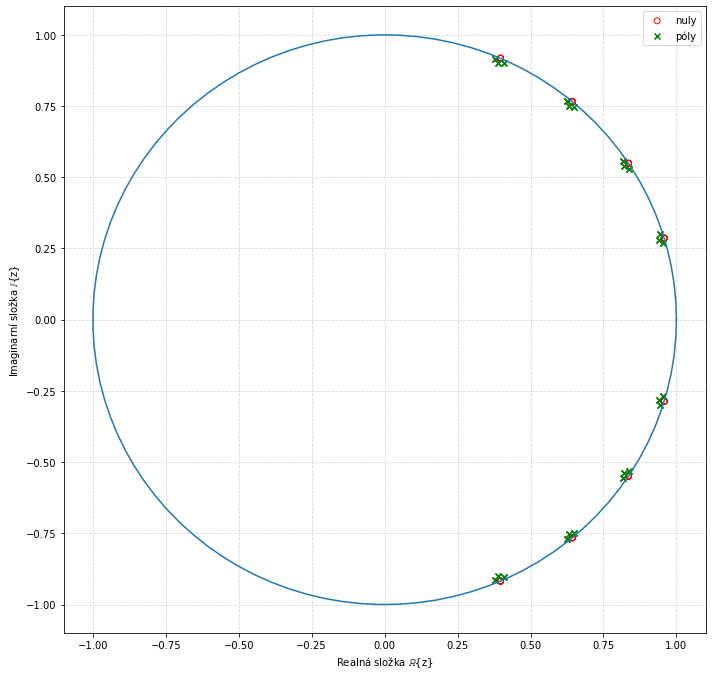

In [28]:
plt.figure(figsize=(10,9.5))
ang = np.linspace(0, 2*np.pi,100)
plt.plot(np.cos(ang), np.sin(ang))

# nuly, poly
plt.scatter(np.real(zeros), np.imag(zeros), marker='o', facecolors='none', edgecolors='r', label='nuly')
plt.scatter(np.real(poles), np.imag(poles), marker='x', color='g', label='póly')

plt.gca().set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
plt.gca().set_ylabel('Imaginarní složka $\mathbb{I}\{$z$\}$')

plt.grid(alpha=0.5, linestyle='--')
plt.legend(loc='upper right')

plt.tight_layout()

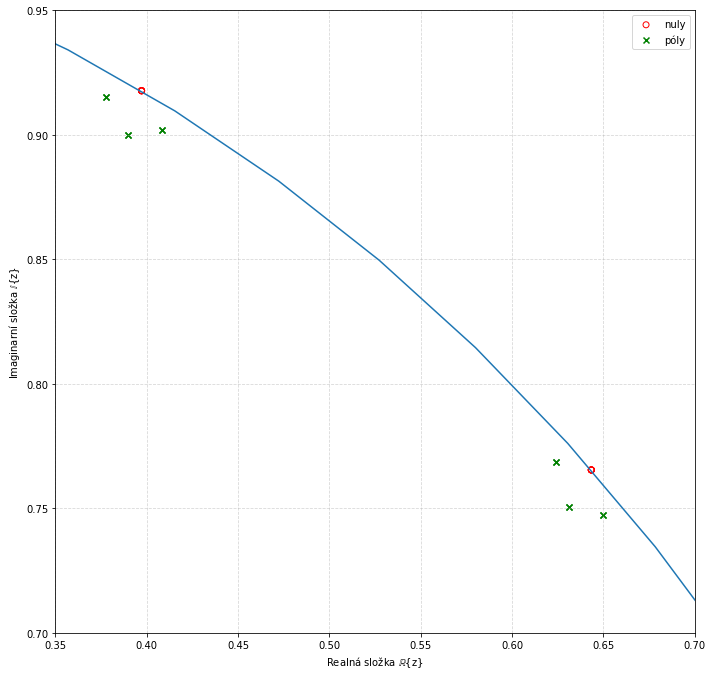

In [29]:
plt.figure(figsize=(10,9.5))
ang = np.linspace(0, 2*np.pi,100)
plt.plot(np.cos(ang), np.sin(ang))

# nuly, poly
plt.scatter(np.real(zeros), np.imag(zeros), marker='o', facecolors='none', edgecolors='r', label='nuly')
plt.scatter(np.real(poles), np.imag(poles), marker='x', color='g', label='póly')

plt.gca().set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
plt.gca().set_ylabel('Imaginarní složka $\mathbb{I}\{$z$\}$')
plt.axis([0.35, 0.7, 0.7, 0.95])

plt.grid(alpha=0.5, linestyle='--')
plt.legend(loc='upper right')

plt.tight_layout()

In [30]:
# Original signal
Audio(data=xfilts[0], rate=Fs)

In [31]:
# filtered base_freq
Audio(data=xfilts[1], rate=Fs)

In [32]:
# filtered base_freq, 2*base_freq
Audio(data=xfilts[2], rate=Fs)

In [33]:
# filtered base_freq, 2*base_freq, 3*base_freq
Audio(data=xfilts[3], rate=Fs)

In [34]:
# filtered 1*base_freq, 2*base_freq, 3*base_freq, 4*base_freq
Audio(data=xfilts[4], rate=Fs)

In [35]:
# DC offset removal
normalized_filtered = copy.deepcopy(xfilts[4])

normalized_filtered = normalized_filtered - np.mean(normalized_filtered)
normalized_filtered = normalized_filtered / np.abs(normalized_filtered).max()

In [36]:
# filtered audio export
wav.write('../audio/clean_bandstop.wav', Fs, normalized_filtered)